In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import psutil
import requests
import seaborn as sns

from utils import *
from datasets import *
from models import *
from transforms import *
from profiler import *

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Available workers: 16


In [23]:
selection = 'peaks>1 & peaks<15 & score>2.5 & score<=20'


# Melanogaster and Suzukii main data

In [34]:
dprof = WingbeatDatasetProfiler(dsname="Wingbeats")

Found 279566 in dataset: Wingbeats, and 6 label(s): ['Ae. aegypti' 'Ae. albopictus' 'An. arabiensis' 'An. gambiae'
 'C. pipiens' 'C. quinquefasciatus']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.


100%|██████████| 20/20 [00:00<00:00, 48.77it/s]


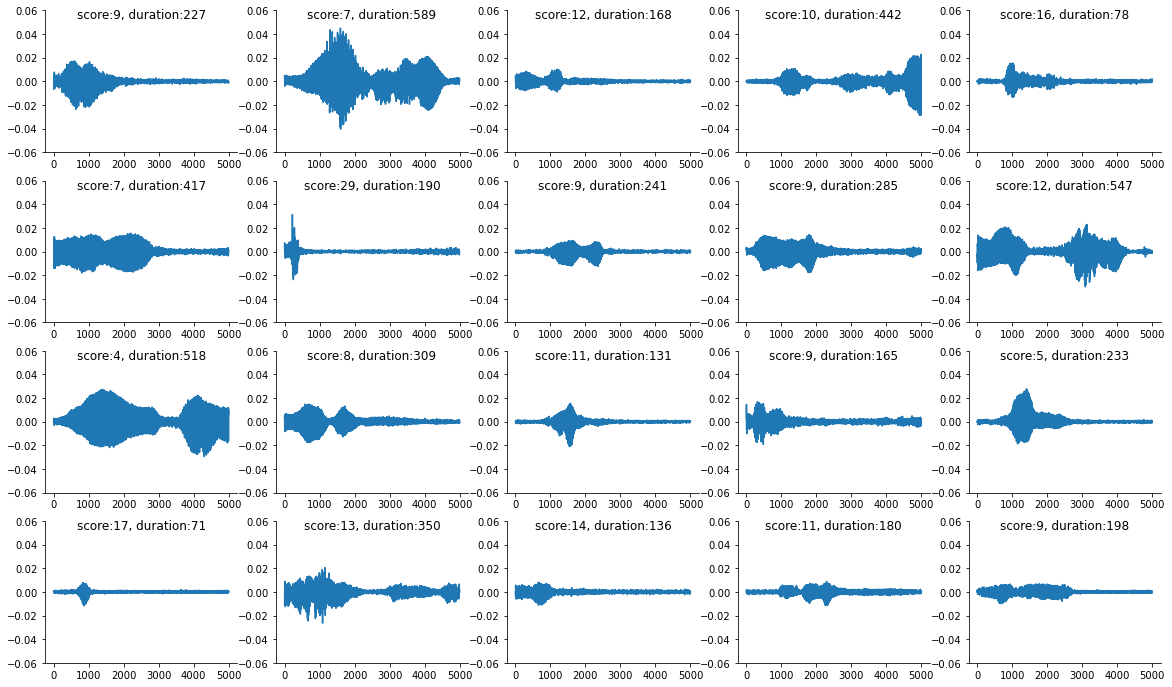

In [35]:
dprof.plot_random_wbts(noaxis=False)

100%|██████████| 20/20 [00:00<00:00, 72.98it/s]


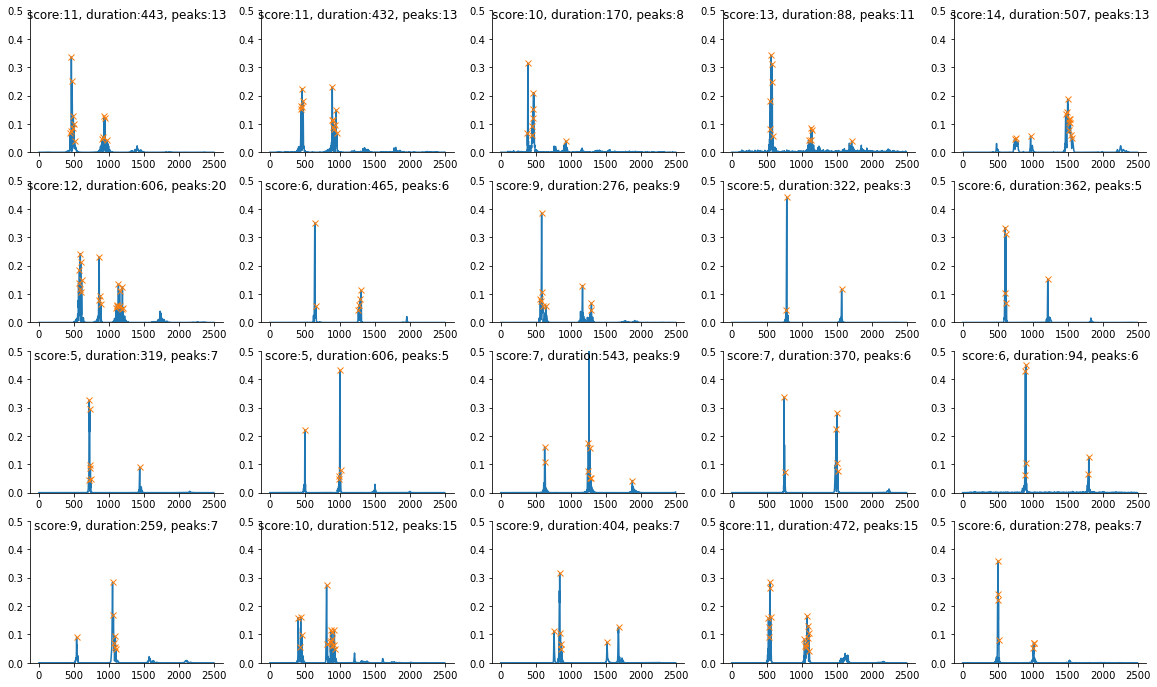

In [36]:
dprof.plot_random_psds(noaxis=False)

In [37]:
# show_peaks(dmel1.psds[1][0].T)

In [38]:
# show_peaks(dmel1.psds[3][0].T)

In [39]:
# plt.figure(figsize=(16,6))
# sns.scatterplot(data=dsuz2.df, x="score", y="peaks", alpha=0.9);
# sns.scatterplot(data=dmel2.df, x="score", y="peaks", alpha=0.3);

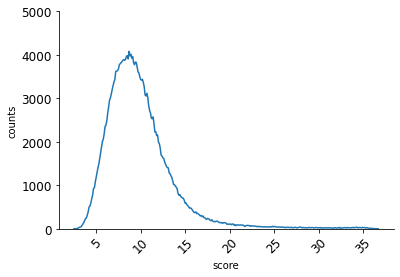

In [49]:
plt.ylim(0,5000)
np_hist(dprof.df, 'score')

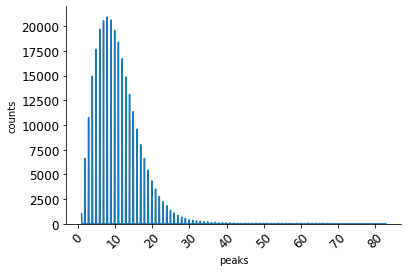

In [56]:
plt.ylim(0,22000)
np_hist(dprof.df, 'peaks')

##### duration

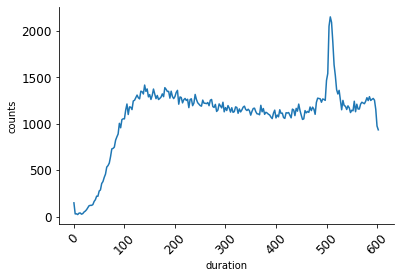

In [57]:
np_hist(dprof.df, 'duration', res=2.5)

In [58]:
dfprof = dprof.df.query(selection)
dfprof.shape

(214143, 12)

### Clean examples

100%|██████████| 20/20 [00:00<00:00, 66.12it/s]


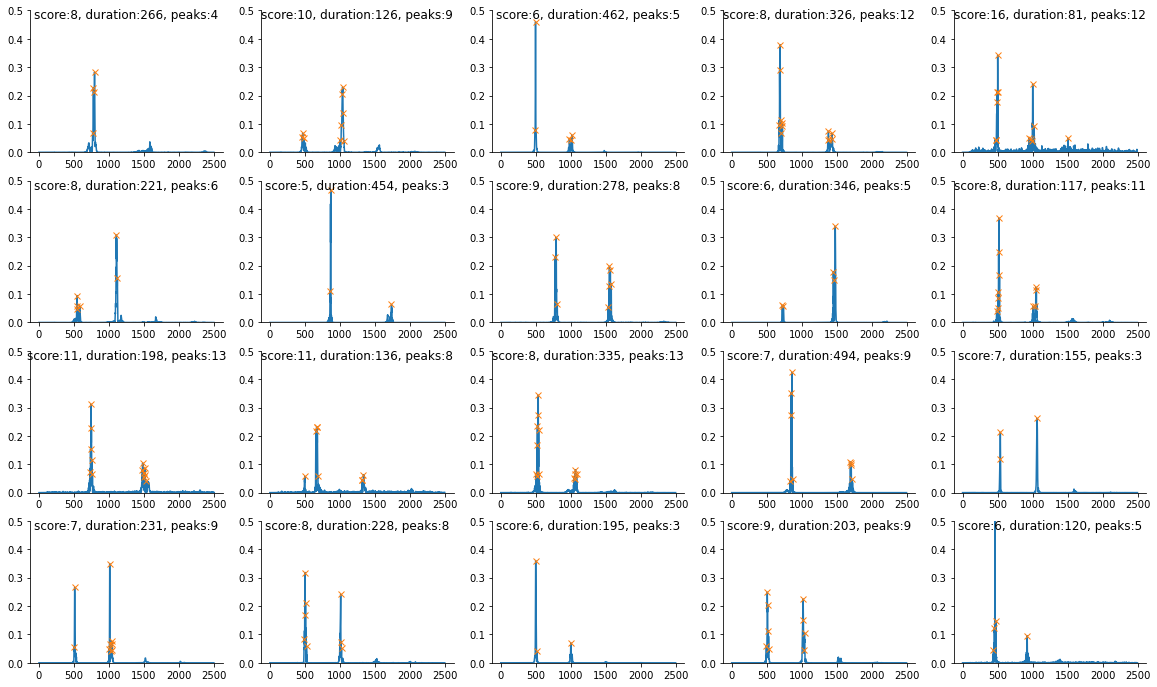

In [59]:
dprof.plot_random_psds(df=dfprof, noaxis=False)

In [60]:
torch.backends.cudnn.benchmark = True
batch_size = 64

In [68]:
dfprof['y'] = dfprof.x.apply(lambda x: x.split('/')[6])

<ipython-input-68-c5d9fa3b3c03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfprof['y'] = dfprof.x.apply(lambda x: x.split('/')[6])


In [71]:
dfprof

,x,y,idx,score,peaks,duration,sum,max,fname,date,datestr,datehourstr
0,/home/kalfasyan/data/wingbeats/Wingbeats/An. arabiensis/D_17_01_31_14_44_50/F170131_145725_210_G_050.wav,An. arabiensis,0,8.422680,4,265.750,16.399048,0.020416,F170131_145725_210_G_050,2017-01-31 14:57:25,20170131,170131_14
2,/home/kalfasyan/data/wingbeats/Wingbeats/An. arabiensis/D_17_01_31_14_44_50/F170131_150427_229_G_050.wav,An. arabiensis,2,10.182297,9,125.875,13.417175,0.034241,F170131_150427_229_G_050,2017-01-31 15:04:27,20170131,170131_15
4,/home/kalfasyan/data/wingbeats/Wingbeats/An. arabiensis/D_17_01_31_14_44_50/F170131_151450_250_G_050.wav,An. arabiensis,4,5.517730,5,461.625,41.518860,0.052643,F170131_151450_250_G_050,2017-01-31 15:14:50,20170131,170131_15
5,/home/kalfasyan/data/wingbeats/Wingbeats/An. arabiensis/D_17_01_31_14_44_50/F170131_151100_244_G_050.wav,An. arabiensis,5,7.858105,12,325.875,22.166199,0.028168,F170131_151100_244_G_050,2017-01-31 15:11:00,20170131,170131_15
6,/home/kalfasyan/data/wingbeats/Wingbeats/An. arabiensis/D_17_01_31_14_44_50/F170131_145900_213_G_050.wav,An. arabiensis,6,15.902831,12,81.000,8.167084,0.016846,F170131_145900_213_G_050,2017-01-31 14:59:00,20170131,170131_14
...,...,...,...,...,...,...,...,...,...,...,...,...
279561,/home/kalfasyan/data/wingbeats/Wingbeats/C. pipiens/D_16_12_06_05_09_04/F161206_051228_069_G_050.wav,C. pipiens,279561,5.186130,4,148.000,15.572601,0.028809,F161206_051228_069_G_050,2016-12-06 05:12:28,20161206,161206_05
279562,/home/kalfasyan/data/wingbeats/Wingbeats/C. pipiens/D_16_12_06_05_09_04/F161206_052102_084_G_050.wav,C. pipiens,279562,3.808230,2,347.250,33.583008,0.032990,F161206_052102_084_G_050,2016-12-06 05:21:02,20161206,161206_05
279563,/home/kalfasyan/data/wingbeats/Wingbeats/C. pipiens/D_16_12_06_05_09_04/F161206_052244_087_G_050.wav,C. pipiens,279563,5.263416,6,392.250,22.158539,0.026428,F161206_052244_087_G_050,2016-12-06 05:22:44,20161206,161206_05
279564,/home/kalfasyan/data/wingbeats/Wingbeats/C. pipiens/D_16_12_06_05_09_04/F161206_053251_104_G_050.wav,C. pipiens,279564,6.189883,4,227.000,24.618439,0.057343,F161206_053251_104_G_050,2016-12-06 05:32:51,20161206,161206_05


In [89]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dfprof, stratify=dfprof.y.tolist(), shuffle=True, random_state=42)

In [90]:
print(train_df.y.value_counts())
print(test_df.y.value_counts())

Ae. aegypti            52245
C. quinquefasciatus    40050
An. gambiae            27811
C. pipiens             19039
An. arabiensis         11442
Ae. albopictus         10020
Name: y, dtype: int64
Ae. aegypti            17415
C. quinquefasciatus    13350
An. gambiae             9270
C. pipiens              6347
An. arabiensis          3814
Ae. albopictus          3340
Name: y, dtype: int64


In [91]:
# dsuz1.plot_random_psds(dfsuz1.sample(len(dfsuz1)))

In [28]:
# train_df.to_csv("../data_created/mosq_train.csv", index=None)
# test_df.to_csv("../data_created/mosq_test.csv", index=None)

In [92]:
train_df.to_parquet("../data_created/mosq_train.parquet")
test_df.to_parquet("../data_created/mosq_test.parquet")

In [21]:
# X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

# dfs_train = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
# dfs_valid = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))

# train_dataloader = DataLoader(dfs_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
# valid_dataloader = DataLoader(dfs_valid, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

## MeBioS Suzukii and Melanogaster data

In [22]:
ds1 = WingbeatDatasetProfiler(dsname="Suzukii_RL/R", custom_label=[1])
ds2 = WingbeatDatasetProfiler(dsname="Suzukii_RL/L", custom_label=[1])
ds3 = WingbeatDatasetProfiler(dsname="Melanogaster_RL/X", custom_label=[0])
ds4 = WingbeatDatasetProfiler(dsname="Melanogaster_RL/W", custom_label=[0])

Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 21940 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 2086 in dataset: Melanogaster_RL/X, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 1882 in dataset: Melanogaster_RL/W, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.


In [23]:
extra_df = pd.concat([ds1.df,ds2.df,ds3.df,ds4.df])

In [31]:
extra_df.y.value_counts()

1    19310
0      936
Name: y, dtype: int64

In [24]:
selection = 'peaks>1 & peaks<10 & score>2.5 & score<=9.5'

In [25]:
extra_df = extra_df.query(selection)

In [26]:
extra_df.to_csv("../data_created/suzmel_extra.csv", index=None)

In [27]:
extra_df.to_parquet("../data_created/suzmel_extra.parquet")

In [79]:
# dpip = WingbeatsDataset(dsname="Wingbeats/C. pipiens", custom_label=[2], clean=True)

# extra_dataset = dpip
# extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

# extra_df = make_df(extra_dataloader, extra_dataset)

# extra_df.to_csv("../data_created/suzmelpip_extra.csv", index=None)

In [45]:
# extra_df